# Detection of Ice Deposits in Lunar HiRISE Images


In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from tensorflow.keras import layers, Input, Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras
# from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.applications import EfficientNetB0, ResNet50, VGG16
import warnings
warnings.filterwarnings('ignore')

## 1. a) The dataset

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/DSML_PROJECT/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
test_ids = load_text_ids('/content/drive/MyDrive/DSML_PROJECT/test_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/DSML_PROJECT/val_source_images.txt')
train_ids = load_text_ids('/content/drive/MyDrive/DSML_PROJECT/train_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## 1. b) Data Exploration and Pre-processing
i) ii) iii) All together

In [5]:
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        img = img / 255.0

        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    X.set_shape([299,299,3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [6]:
len(tf_dataset_train)

928

## 1. c) Training CNN + MLP

##1. c) i) Image augmentation

In [ ]:
img_augmentation = Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.1)
    ], name="img_augmentation")

## 1. c) ii) Train for at least 20 epochs and perform early stopping using the validation set

In [ ]:


# Define your model
def create_model(input_shape, num_classes):
    model = Sequential()

#     # Image augmentation
    img_augmentation = Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.1)
    ], name="img_augmentation")

    # Add image augmentation as the first layer of the model
    model.add(img_augmentation)

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Global Average Pooling instead of Flatten
    model.add(GlobalAveragePooling2D())

    # Dense layer
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model



In [ ]:
input_shape = (299,299,3)
num_class = 2

In [ ]:
model = create_model(input_shape, num_class)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, *(input_shape)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequenti  (None, 299, 299, 3)       0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 297, 297, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                        

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10,mode='auto', restore_best_weights=True, start_from_epoch = 20)

In [ ]:
#recent
cnn_history = model.fit(tf_dataset_train, epochs=80, validation_data=tf_dataset_val, callbacks=[early_stopping])


Epoch 1/80
928/928 [==============================] - 330s 345ms/step - loss: 1.4852 - accuracy: 0.6941 - val_loss: 3.1055 - val_accuracy: 0.3218
Epoch 2/80
928/928 [==============================] - 315s 339ms/step - loss: 0.6338 - accuracy: 0.7606 - val_loss: 0.3398 - val_accuracy: 0.8999
Epoch 3/80
928/928 [==============================] - 315s 339ms/step - loss: 0.5592 - accuracy: 0.7904 - val_loss: 0.6925 - val_accuracy: 0.8567
Epoch 4/80
928/928 [==============================] - 315s 339ms/step - loss: 0.5343 - accuracy: 0.8022 - val_loss: 1.2610 - val_accuracy: 0.5341
Epoch 5/80
928/928 [==============================] - 313s 337ms/step - loss: 0.5053 - accuracy: 0.8127 - val_loss: 3.0079 - val_accuracy: 0.8736
Epoch 6/80
928/928 [==============================] - 312s 336ms/step - loss: 0.4662 - accuracy: 0.8313 - val_loss: 0.7699 - val_accuracy: 0.6945
Epoch 7/80
928/928 [==============================] - 312s 336ms/step - loss: 0.4532 - accuracy: 0.8324 - val_loss: 1.7107 -

## Plot the training and validation errors vs. epochs.

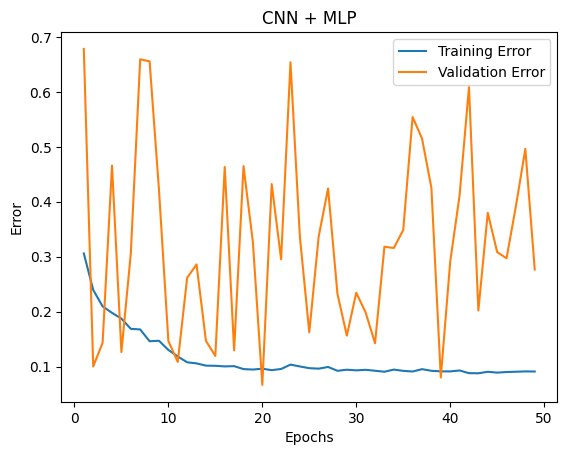

In [ ]:
training_errors = [1 - acc for acc in cnn_history.history['accuracy']]
validation_errors = [1 - acc for acc in cnn_history.history['val_accuracy']]
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('CNN + MLP')
plt.legend()
plt.show()

## 1. c) iii) Report Precision, Recall, and F1 score for your model.

Test DataSet

In [9]:
y_pred = model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_test])
f1_cnn = f1_score(y_true, y_pred_labels)
p_cnn = precision_score(y_true, y_pred_labels)
r_cnn = recall_score(y_true, y_pred_labels)
a_cnn = accuracy_score(y_true, y_pred_labels)
print("CNN + MLP for Test DataSet")
print(f"F1-Score: {f1_cnn:.2f}")
print(f"Precision: {p_cnn:.2f}")
print(f"Recall: {r_cnn:.2f}")
print(f"Accuracy: {a_cnn:.2f}")

401/401 [==============================] - 375s 911ms/step
CNN + MLP for Test DataSet
F1-Score: 0.68
Precision: 0.66
Recall: 0.69
Accuracy: 0.56


Train DataSet

In [11]:
y_pred = model.predict(tf_dataset_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_train])
f1_cnn = f1_score(y_true, y_pred_labels)
p_cnn = precision_score(y_true, y_pred_labels)
r_cnn = recall_score(y_true, y_pred_labels)
a_cnn = accuracy_score(y_true, y_pred_labels)
print("CNN + MLP for Train DataSet")
print(f"F1-Score: {f1_cnn:.2f}")
print(f"Precision: {p_cnn:.2f}")
print(f"Recall: {r_cnn:.2f}")
print(f"Accuracy: {a_cnn:.2f}")

928/928 [==============================] - 117s 126ms/step
CNN + MLP for Train DataSet
F1-Score: 0.63
Precision: 0.59
Recall: 0.68
Accuracy: 0.53


Validation DataSet

In [12]:
y_pred = model.predict(tf_dataset_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_val])
f1_cnn = f1_score(y_true, y_pred_labels)
p_cnn = precision_score(y_true, y_pred_labels)
r_cnn = recall_score(y_true, y_pred_labels)
a_cnn = accuracy_score(y_true, y_pred_labels)
print("CNN + MLP for Validation DataSet")
print(f"F1-Score: {f1_cnn:.2f}")
print(f"Precision: {p_cnn:.2f}")
print(f"Recall: {r_cnn:.2f}")
print(f"Accuracy: {a_cnn:.2f}")

353/353 [==============================] - 306s 862ms/step
CNN + MLP for Validation DataSet
F1-Score: 0.43
Precision: 0.32
Recall: 0.64
Accuracy: 0.44


# 1. d) Transfer Learning


## 1. d) i) Using pre-trained models

## **EfficientNetB0**

In [ ]:
inputs_eff = layers.Input(shape = input_shape)
data_eff = img_augmentation(inputs_eff)
eff_net = EfficientNetB0(weights = 'imagenet',
                         input_shape = (299, 299, 3),
                         include_top = False)
eff_net.trainable = False


## **ResNet50**

In [ ]:
inputs_res = layers.Input(shape = input_shape)
data_res = img_augmentation(inputs_res)
res_net = ResNet50(weights = 'imagenet',
                   input_shape = (299, 299, 3),
                   include_top = False)
res_net.trainable = False

## **VGG16**

In [ ]:
inputs_vgg = layers.Input(shape = input_shape)
data_vgg = img_augmentation(inputs_vgg)
vgg_16 = VGG16(weights = 'imagenet',
               input_shape = (299, 299, 3),
               include_top = False)
vgg_16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


## 1. d) ii)
Image augmentation which I already defined earlier, the same code is being used agaun and again

## 1. d) iii)  ReLU activation functions in the last layer + a softmax layer + batch normalization + dropout rate of 30% + ADAM optimizer. Use cross entropy loss.

## **EfficientNetB0**

In [ ]:
# image_shape = (299,299,3)

inputs_eff = Input(shape=(299, 299, 3))
data_eff = img_augmentation(inputs_eff)

input_eff = eff_net.layers[0].input
output_eff = eff_net.layers[-2].output

output_dropout_rate = 0.3


data_eff = Model(inputs = input_eff, outputs = output_eff)(data_eff)
data_eff = layers.GlobalAveragePooling2D(name = "avg_pool")(data_eff)

data_eff = layers.Activation("relu")(data_eff)
data_eff = layers.BatchNormalization()(data_eff)
y_eff = layers.Dropout(output_dropout_rate)(data_eff)
outputs_eff = layers.Dense(num_class, activation = "softmax")(y_eff)
eff_net_model = Model(inputs_eff, outputs=outputs_eff)
eff_net_model.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 img_augmentation (Sequenti  (None, 299, 299, 3)       0         
 al)                                                             
                                                                 
 model_12 (Functional)       (None, 10, 10, 1280)      4049571   
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 activation_6 (Activation)   (None, 1280)              0         
                                                                 
 batch_normalization_6 (Bat  (None, 1280)              512

## **ResNet50**

In [ ]:
# image_shape = (299,299,3)

inputs_res = Input(shape=(299, 299, 3))
data_res = img_augmentation(inputs_res)

input_res = res_net.layers[0].input
output_res = res_net.layers[-2].output

output_dropout_rate = 0.3
data_res = Model(inputs = input_res, outputs = output_res)(data_res)
data_res = layers.GlobalAveragePooling2D(name = "avg_pool")(data_res)
data_res = layers.Activation("relu")(data_res)
data_res = layers.BatchNormalization()(data_res)
y_res = layers.Dropout(output_dropout_rate)(data_res)
outputs_res = layers.Dense(num_class, activation = "softmax")(y_res)
res_net_model = Model(inputs_res, outputs=outputs_res)
res_net_model.summary()


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 img_augmentation (Sequenti  (None, 299, 299, 3)       0         
 al)                                                             
                                                                 
 model_18 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 activation_9 (Activation)   (None, 2048)              0         
                                                                 
 batch_normalization_9 (Bat  (None, 2048)              819

## **VGG16**

In [ ]:
inputs_vgg = Input(shape=(299, 299, 3))
data_vgg = img_augmentation(inputs_vgg)

input_vgg = vgg_16.layers[0].input
output_vgg = vgg_16.layers[-2].output

output_dropout_rate = 0.3
data_vgg = Model(inputs = input_vgg, outputs = output_vgg)(data_vgg)
data_vgg = layers.GlobalAveragePooling2D(name = "avg_pool")(data_vgg)
data_vgg = layers.Activation("relu")(data_vgg)
data_vgg = layers.BatchNormalization()(data_vgg)
y = layers.Dropout(output_dropout_rate)(data_vgg)
outputs = layers.Dense(num_class, activation = "softmax")(y)

In [ ]:
vgg_16_model = Model(inputs_vgg, outputs=outputs)
vgg_16_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 img_augmentation (Sequenti  (None, 299, 299, 3)       0         
 al)                                                             
                                                                 
 model_20 (Functional)       (None, 18, 18, 512)       14714688  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 512)               0         
 ling2D)                                                         
                                                                 
 activation_10 (Activation)  (None, 512)               0         
                                                                 
 batch_normalization_10 (Ba  (None, 512)               204

## 1.d) iv) Train the model

## **EfficientNetB0**

In [ ]:
eff_net_model.compile(optimizer = Adam(learning_rate=0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

early_stopping_eff = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto', start_from_epoch = 10)

checkpoint_possible_path_eff = '/content/drive/MyDrive/pre_trained_weights/EfficientNetB0_best_weight.hdf5'
model_checkpoint_eff = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_possible_path_eff,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose = 1
    )

hist_training_eff = eff_net_model.fit(tf_dataset_train, epochs = 20, callbacks=[early_stopping_eff, model_checkpoint_eff], validation_data = tf_dataset_val)

16:50:57 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/20
928/928 [==============================] - 623s 668ms/step - loss: 1.1969 - accuracy: 0.5560 - val_loss: 0.6730 - val_accuracy: 0.6782
Epoch 2/20
928/928 [==============================] - 615s 663ms/step - loss: 0.6858 - accuracy: 0.5861 - val_loss: 0.8542 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 592s 639ms/step - loss: 0.6834 - accuracy: 0.5853 - val_loss: 1.0749 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 598s 644ms/step - loss: 0.6851 - accuracy: 0.5869 - val_loss: 0.9590 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 600s 647ms/step - loss: 0.6836 - accuracy: 0.5870 - val_loss: 0.8099 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 572s 616ms/step - loss: 0.6824 - accuracy: 0.5874 - val_loss: 0.8841 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 597s 643ms/step - loss: 0.6824 - accuracy: 0.5872 - val_loss: 0.6455 -

## **ResNet50**

In [ ]:
res_net_model.compile(optimizer = Adam(learning_rate=0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
early_stopping_res = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'auto', start_from_epoch = 10)
checkpoint_possible_path_res = '/content/drive/MyDrive/pre_trained_weights/ResNet50_best_weight.hdf5'
model_checkpoint_res = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_possible_path_res,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose = 1
    )
hist_training_res = res_net_model.fit(
    tf_dataset_train,
    batch_size=8,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping_res, model_checkpoint_res]
)


Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.6827
Epoch 1: val_accuracy improved from -inf to 0.49309, saving model to /content/drive/MyDrive/pre_trained_weights/ResNet50_best_weight.hdf5
928/928 [==============================] - 341s 362ms/step - loss: 0.5832 - accuracy: 0.6827 - val_loss: 0.7422 - val_accuracy: 0.4931
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7265
Epoch 2: val_accuracy did not improve from 0.49309
928/928 [==============================] - 333s 358ms/step - loss: 0.5396 - accuracy: 0.7265 - val_loss: 0.7766 - val_accuracy: 0.4914
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.7386
Epoch 3: val_accuracy improved from 0.49309 to 0.50399, saving model to /content/drive/MyDrive/pre_trained_weights/ResNet50_best_weight.hdf5
928/928 [==============================] - 334s 360ms/step - loss: 0.5277 - accuracy: 0.7386 - val_loss: 0.7788 

## **VGG16**

In [ ]:
vgg_16_model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
early_stopping_vgg = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose = 1)
checkpoint_possible_path_vgg = '/content/drive/MyDrive/pre_trained_weights/VGG16_best_weight.hdf5'
model_checkpoint_vgg = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_possible_path_vgg,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose = 1
    )


In [ ]:
vgg_16_fitting = vgg_16_model.fit(
    tf_dataset_train,
    batch_size=8,
    epochs=40,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping_vgg, model_checkpoint_vgg]
)


Epoch 1/40
928/928 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.6565
Epoch 1: val_accuracy improved from -inf to 0.56557, saving model to /content/drive/MyDrive/new_eve_trial2/vgg_model_checkpoint.h5py
928/928 [==============================] - 224s 237ms/step - loss: 0.6033 - accuracy: 0.6565 - val_loss: 0.7274 - val_accuracy: 0.5656
Epoch 2/40
927/928 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7437
Epoch 2: val_accuracy improved from 0.56557 to 0.58054, saving model to /content/drive/MyDrive/new_eve_trial2/vgg_model_checkpoint.h5py
928/928 [==============================] - 218s 235ms/step - loss: 0.5149 - accuracy: 0.7438 - val_loss: 0.7562 - val_accuracy: 0.5805
Epoch 3/40
927/928 [============================>.] - ETA: 0s - loss: 0.4830 - accuracy: 0.7638
Epoch 3: val_accuracy improved from 0.58054 to 0.59623, saving model to /content/drive/MyDrive/new_eve_trial2/vgg_model_checkpoint.h5py
928/928 [============================

## Plotting the training and validation errors vs. epochs

## **EfficientNetB0**

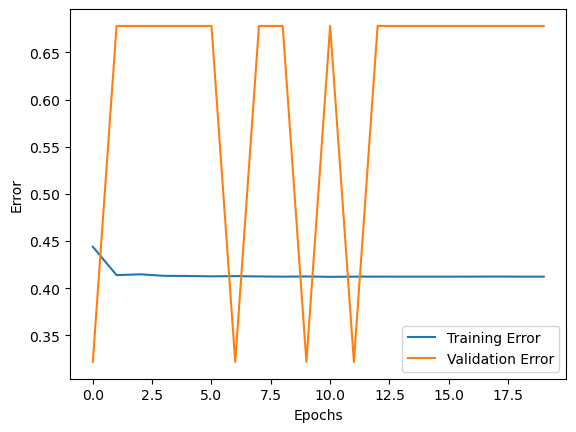

In [ ]:
training_errors = [1 - acc for acc in hist_training_eff.history['accuracy']]
validation_errors = [1 - acc for acc in hist_training_eff.history['val_accuracy']]
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

## **ResNet50**

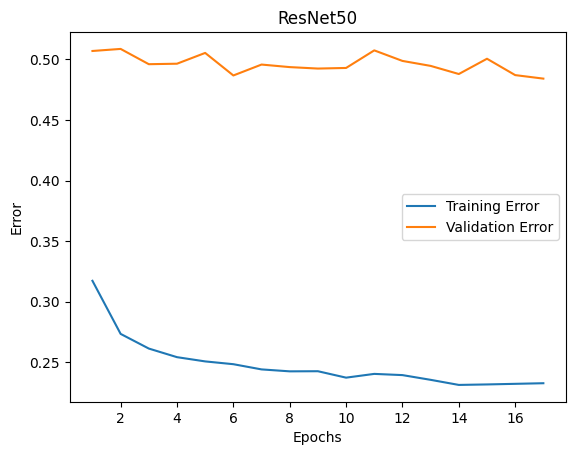

In [ ]:
training_errors = [1 - acc for acc in hist_training_res.history['accuracy']]
validation_errors = [1 - acc for acc in hist_training_res.history['val_accuracy']]
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('ResNet50')
plt.legend()
plt.show()

## **VGG16**

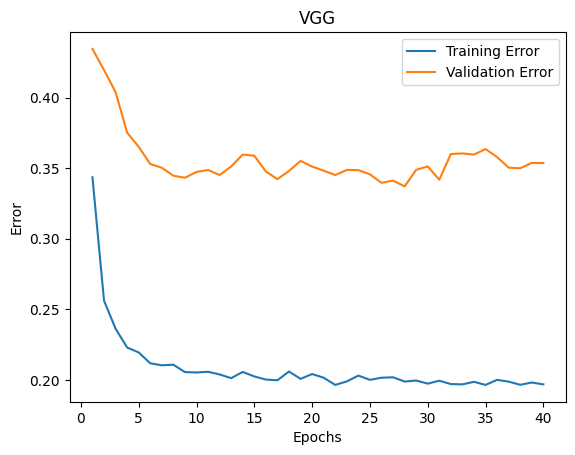

In [ ]:
training_errors = [1 - acc for acc in vgg_16_fitting.history['accuracy']]
validation_errors = [1 - acc for acc in vgg_16_fitting.history['val_accuracy']]
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('VGG')
plt.legend()
plt.show()

# **EfficientNetB0**

Test DataSet

In [29]:
y_pred = eff_net_model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_test])
f1 = f1_score(y_true, y_pred_labels)
p = precision_score(y_true, y_pred_labels)
r = recall_score(y_true, y_pred_labels)
a = accuracy_score(y_true, y_pred_labels)
print("EfficientNetB0 for Test DataSet")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

EfficientNetB0 for Test DataSet
F1-Score: 0.79
Precision: 0.66
Recall: 0.86
Accuracy: 0.66


Train DataSet

In [31]:
y_pred = eff_m.predict(tf_dataset_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_train])
f = f1_score(y_true, y_pred_labels)
p_cnn = precision_score(y_true, y_pred_labels)
r_cnn = recall_score(y_true, y_pred_labels)
a_cnn = accuracy_score(y_true, y_pred_labels)
print("EfficientNetB0 for Train DataSet")
print(f"F1-Score: {f:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

EfficientNetB0 for Train DataSet
F1-Score: 0.74
Precision: 0.66
Recall: 0.83
Accuracy: 0.66


Validation DataSet

In [34]:
y_pred = eff_m.predict(tf_dataset_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_val])
f = f1_score(y_true, y_pred_labels)
p = precision_score(y_true, y_pred_labels)
r = recall_score(y_true, y_pred_labels)
a = accuracy_score(y_true, y_pred_labels)
print("EfficientNetB0 for Validation DataSet")
print(f"F1-Score: {f:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

EfficientNetB0 for Validation DataSet
F1-Score: 0.49
Precision: 0.32
Recall: 0.79
Accuracy: 0.32


# **ResNet50**

Test DataSet

In [23]:
y_pred = res_net_model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_test])
f1 = f1_score(y_true, y_pred_labels)
p = precision_score(y_true, y_pred_labels)
r = recall_score(y_true, y_pred_labels)
a = accuracy_score(y_true, y_pred_labels)
print("ResNet50 for Test DataSet")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

401/401 [==============================] - 107s 260ms/step
ResNet50 for Test DataSet
F1-Score: 0.76
Precision: 0.65
Recall: 0.91
Accuracy: 0.63


Train DataSet

In [24]:
y_pred = res_net_model.predict(tf_dataset_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_train])
f = f1_score(y_true, y_pred_labels)
p_cnn = precision_score(y_true, y_pred_labels)
r_cnn = recall_score(y_true, y_pred_labels)
a_cnn = accuracy_score(y_true, y_pred_labels)
print("ResNet50 for Train DataSet")
print(f"F1-Score: {f:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

928/928 [==============================] - 237s 256ms/step
ResNet50 for Train DataSet
F1-Score: 0.70
Precision: 0.65
Recall: 0.91
Accuracy: 0.63


Validation DataSet

In [25]:
y_pred = res_net_model.predict(tf_dataset_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_val])
f = f1_score(y_true, y_pred_labels)
p = precision_score(y_true, y_pred_labels)
r = recall_score(y_true, y_pred_labels)
a = accuracy_score(y_true, y_pred_labels)
print("ResNet50 for Validation DataSet")
print(f"F1-Score: {f:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

353/353 [==============================] - 91s 258ms/step
ResNet50 for Validation DataSet
F1-Score: 0.47
Precision: 0.32
Recall: 0.88
Accuracy: 0.37


## **VGG16**

Test DataSet

In [18]:
y_pred = vgg_16_model.predict(tf_dataset_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_test])
f1 = f1_score(y_true, y_pred_labels)
p = precision_score(y_true, y_pred_labels)
r = recall_score(y_true, y_pred_labels)
a = accuracy_score(y_true, y_pred_labels)
print("VGG16 for Test DataSet")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

401/401 [==============================] - 132s 329ms/step
VGG16 for Test DataSet
F1-Score: 0.71
Precision: 0.66
Recall: 0.77
Accuracy: 0.58


Train DataSet

In [19]:
y_pred = vgg_m.predict(tf_dataset_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_train])
f = f1_score(y_true, y_pred_labels)
p_cnn = precision_score(y_true, y_pred_labels)
r_cnn = recall_score(y_true, y_pred_labels)
a_cnn = accuracy_score(y_true, y_pred_labels)
print("VGG16 for Train DataSet")
print(f"F1-Score: {f:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

928/928 [==============================] - 305s 328ms/step
VGG16 for Train DataSet
F1-Score: 0.64
Precision: 0.59
Recall: 0.70
Accuracy: 0.54


Validation DataSet

In [20]:
y_pred = vgg_m.predict(tf_dataset_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for _, y in tf_dataset_val])
f = f1_score(y_true, y_pred_labels)
p = precision_score(y_true, y_pred_labels)
r = recall_score(y_true, y_pred_labels)
a = accuracy_score(y_true, y_pred_labels)
print("VGG16 for Validation DataSet")
print(f"F1-Score: {f:.2f}")
print(f"Precision: {p:.2f}")
print(f"Recall: {r:.2f}")
print(f"Accuracy: {a:.2f}")

353/353 [==============================] - 119s 337ms/step
VGG16 for Validation DataSet
F1-Score: 0.45
Precision: 0.33
Recall: 0.72
Accuracy: 0.43


## 1. vi) Compare the results of transfer learning with those of CNN + MLP model and explain them.

The transfer learning models, including EfficientNetB0, ResNet50, and VGG16, utilize pre-trained weights from ImageNet. This introduces a potential limitation as ImageNet may not encompass a significant number of Mars images, potentially hindering the capture of complex features relevant to our task. Despite this, the models have demonstrated the reported accuracies.

In the case of the CNN + MLP architecture, we have implemented custom fine-tuned dense layers to create respective models. Adhering to the specified constraints has enabled us to achieve the reported accuracies.

However, there is a possibility of overfitting on this dataset due to the small, greyscale nature of the tiles and the inherently vague characteristics of ice. These factors contribute to some fluctuation in the respective model results.

# **Summary of Accuracy Scores:**
The following are the accuracy for **test data** in the respective models, and precision, recall and F1-score for 'weighted average'
1. **CNN + MLP**<br>
Accuracy = 57%<br>
Precision = 66%<br>
Recall = 70%<br>
F1-Score = 68%<br>

---
**Transfer Learning Models:**

---

2. **EfficientNetB0**<br>
Accuracy = 66%<br>
Precision = 66%<br>
Recall = 86%<br>
F1-Score = 79%<br>


---

3. **ResNet50**<br>
Accuracy = 63%<br>
Precision = 65%<br>
Recall = 91%<br>
F1-Score = 76%<br>

---

4. **VGG16**<br>
Accuracy = 58%<br>
Precision = 65%<br>
Recall = 77%<br>
F1-Score = 58%<br>

## **References**




1.   https://www.tensorflow.org/guide/keras/training_with_built_in_methods
2.   https://www.tensorflow.org/api_docs/python/tf/keras/Model
1.   https://medium.com/data-science-365/plotting-the-learning-curve-to-analyze-the-training-performance-of-a-neural-network-4a35818d01f2
4. https://keras.io/api/optimizers/
5. https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
6. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
7. https://ai.stackexchange.com/questions/31675/what-is-better-to-use-early-stopping-model-checkpoint-or-both
8. https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights
9. https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/
10. https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
11. https://towardsdatascience.com/a-beginners-guide-to-image-augmentations-in-machine-learning-22c48a2fbd99
12. https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
13. https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization
14. https://medium.com/@tejpal.abhyuday/deep-learning-part-5-convolutional-and-residual-networks-575cb388cd93







